#### Copyright 2017 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Regresi Logistik

**Tujuan Pembelajaran:**
  * Membingkai ulang prediktor dari median nilai rumah (dari latihan sebelumnya) sebagai model klasifikasi biner
  * Membandingkan efektivitas regresi logistik dengan regresi linear untuk masalah klasifikasi biner

Seperti pada latihan sebelumnya, kita menggunakan [kumpulan data perumahan di California](https://developers.google.com/machine-learning/crash-course/california-housing-data-description), tetapi kali ini kita akan mengubahnya menjadi masalah klasifikasi biner dengan memprediksi apakah blok kota memiliki ongkos tinggi atau tidak. Untuk saat ini, kita juga akan kembali ke fitur default.

## Membingkai Masalah sebagai Klasifikasi Biner

Target kumpulan data kita adalah `median_house_value` yang merupakan fitur numerik (nilai berkelanjutan). Kita dapat membuat label (logika) boolean dengan menerapkan batas klasifikasi tersebut ke nilai yang berkelanjutan ini.

Dengan fitur yang menggambarkan blok kota, kita ingin memprediksi apakah blok kota memiliki ongkos yang tinggi atau tidak. Untuk menyiapkan target guna melatih dan mengevaluasi data, kita menentukan batas klasifikasi sebesar 75%-ile untuk nilai median rumah (nilainya sekitar 265000). Semua nilai rumah di atas batas klasifikasi tersebut diberi label `1`, dan semua nilai yang lain diberi label `0`.

## Penyiapan

Jalankan sel di bawah untuk memuat data dan menyiapkan target dan fitur masukan.

In [2]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

TensorFlow 1.x selected.


Perhatikan bagaimana kode di bawah sedikit berbeda dari latihan sebelumnya. Kita membuat target biner baru, yaitu `median_house_value_is_high`, bukannya menggunakan `median_house_value` sebagai target.

In [5]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # median_house_value is above a set threshold.
  output_targets["median_house_value_is_high"] = (
    california_housing_dataframe["median_house_value"] > 265000).astype(float)
  return output_targets

In [6]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2657.5,541.4,1434.2,503.3,3.9,2.0
std,2.1,2.0,12.6,2229.3,431.6,1184.6,393.5,1.9,1.2
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1464.8,295.0,789.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2131.0,434.0,1167.0,409.0,3.6,2.0
75%,37.7,-118.0,37.0,3166.0,651.0,1728.0,607.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.7,2610.5,534.7,1418.5,496.2,3.8,2.0
std,2.1,2.0,12.6,2056.5,396.1,1054.4,362.2,1.8,1.2
min,32.6,-124.3,2.0,2.0,2.0,6.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1455.8,299.0,791.0,283.8,2.6,1.5
50%,34.2,-118.5,29.0,2119.0,434.0,1167.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3118.2,642.2,1707.2,599.0,4.7,2.3
max,41.9,-114.6,52.0,28258.0,3945.0,12203.0,3790.0,15.0,52.0


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


## Bagaimana Efektivitas Regresi Linear?
Untuk melihat mengapa regresi logistik efektif, mari latih model naif yang menggunakan regresi linear terlebih dahulu. Model ini akan menggunakan label dengan nilai dalam set `{0, 1}` dan akan mencoba memprediksi nilai berkelanjutan sedekat mungkin ke angka `0` atau `1`. Selanjutnya, kita ingin menginterpretasikan keluaran sebagai probabilitas, sehingga akan ideal jika keluaran berada dalam rentang `(0, 1)`. Kemudian, kita akan menerapkan batas klasifikasi tersebut sebesar `0.5` untuk menentukan label.

Jalankan sel di bawah untuk melatih model regresi linear menggunakan [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor).

In [7]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [8]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
def train_linear_regressor_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 0.45
  period 01 : 0.45
  period 02 : 0.45
  period 03 : 0.45
  period 04 : 0.45
  period 05 : 0.45
  period 06 : 0.44
  period 07 : 0.45
  period 08 : 0.44
  period 09 : 0.44
Model training finished.


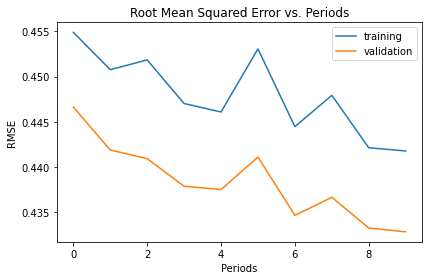

In [11]:
linear_regressor = train_linear_regressor_model(
    learning_rate=0.000001,
    steps=200,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Tugas 1: Dapatkah Kita Menghitung KerugianLog untuk Prediksi Ini?

**Periksa prediksi dan putuskan apakah kita dapat menggunakannya untuk menghitung KerugianLog atau tidak.**

`LinearRegressor` menggunakan kerugian L2, yang tidak berfungsi dengan baik dalam menghukum kesalahan klasifikasi ketika keluaran diinterpretasikan sebagai probabilitas. Misalnya, seharusnya ada perbedaan besar apakah contoh negatif diklasifikasikan sebagai positif dengan probabilitas sebesar 0,9 vs 0,9999, namun kerugian L2 tidak terlalu membedakan kasus tersebut.

Sebaliknya, `LogLoss` menghukum "error keyakinan" ini dengan jauh lebih berat. Perlu diingat, `LogLoss` didefinisikan sebagai:

$$Kerugian Log = \sum_{(x,y)\in D} -y \cdot log(y_{pred}) - (1 - y) \cdot log(1 - y_{pred})$$


Tapi kita harus mendapatkan nilai prediksi terlebih dahulu. Kita dapat menggunakan `LinearRegressor.predict` untuk memperoleh nilai ini.

Dengan prediksi dan target yang ditentukan, dapatkah kita menghitung `LogLoss`?

### Solusi

Klik di bawah ini untuk menampilkan solusi.

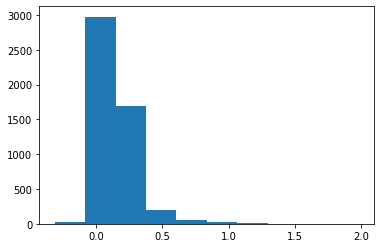

In [12]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

_ = plt.hist(validation_predictions)

## Tugas 2: Melatih Model Regresi Logistik dan Menghitung KerugianLog pada Set Validasi

Untuk menggunakan regresi logistik, cukup gunakan [LinearClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) sebagai ganti `LinearRegressor`. Selesaikan kode di bawah.

**CATATAN**: Saat menjalankan `train()` dan `predict()` pada model `LinearClassifier`, Anda dapat mengakses nilai prediksi probabilitas melalui kunci `"probabilities"` di kamus yang ditampilkan—misalnya, `predictions["probabilities"]`. Fungsi [log_loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) Sklearn mudah digunakan untuk menghitung KerugianLog dengan menggunakan probabilitas ini.


In [14]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer)

    
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

Training model...
LogLoss (on training data):
  period 00 : 0.60
  period 01 : 0.58
  period 02 : 0.57
  period 03 : 0.56
  period 04 : 0.55
  period 05 : 0.54
  period 06 : 0.54
  period 07 : 0.54
  period 08 : 0.54
  period 09 : 0.53
Model training finished.


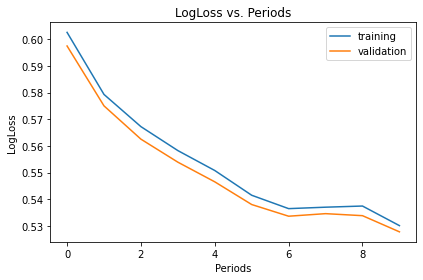

In [15]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Solusi

Klik di bawah untuk melihat solusinya.



In [ ]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

In [ ]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Tugas 3: Menghitung Akurasi dan menggambarkan Kurva KOP untuk Set Validasi

Beberapa metrik yang berguna untuk klasifikasi adalah [akurasi](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification) model, [kurva KOP](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) dan area di Bawah kurva KOP (ABK). Kita akan memeriksa metrik ini.

`LinearClassifier.evaluate` akan menghitung metrik yang berguna seperti akurasi dan ABK.

In [16]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

AUC on the validation set: 0.75
Accuracy on the validation set: 0.77


Anda dapat menggunakan probabilitas kelas, seperti probabilitas yang dihitung berdasarkan `LinearClassifier.predict`, dan [roc_curve](http://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) Sklearn untuk memperoleh rasio positif palsu dan positif benar yang diperlukan guna menggambarkan kurva KOP.

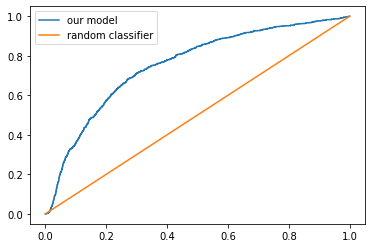

In [17]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

**Lihat apakah Anda dapat menyesuaikan setelan pembelajaran dari model yang dilatih di Tugas 2 untuk meningkatkan ABK.**

Sering kali, metrik tertentu meningkat tapi merugikan metrik lain, dan Anda harus menemukan setelan yang mencapai kompromi yang baik.

**Verifikasi apakah semua metrik meningkat pada saat yang bersamaan.**

Training model...
LogLoss (on training data):
  period 00 : 0.60
  period 01 : 0.58
  period 02 : 0.57
  period 03 : 0.55
  period 04 : 0.56
  period 05 : 0.56
  period 06 : 0.54
  period 07 : 0.53
  period 08 : 0.54
  period 09 : 0.53
Model training finished.
AUC on the validation set: 0.75
Accuracy on the validation set: 0.77


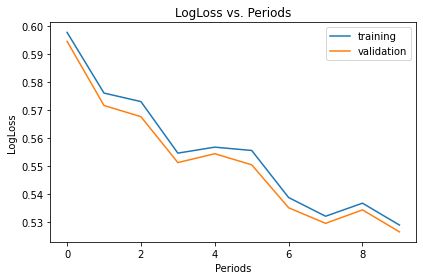

In [18]:
# TUNE THE SETTINGS BELOW TO IMPROVE AUC
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

### Solusi

Klik di bawah untuk mendapatkan solusi yang mungkin.

Satu solusi yang mungkin berfungsi adalah cukup dengan melatih model lebih lama, selama tidak sampai overfitting.

Kita dapat melakukan tindakan ini dengan menambah jumlah langkah, ukuran tumpukan, atau keduanya.

Semua metrik meningkat pada saat yang bersamaan, sehingga metrik kerugian kita adalah proxy yang baik bagi ABK dan akurasi.

Perhatikan bagaimana prosesnya membutuhkan lebih banyak iterasi hanya untuk menekan beberapa unit ABK. Hal ini umum terjadi. Namun seringkali keuntungan kecil seperti ini pun sangat berharga, sesuai dengan ongkosnya.

Training model...
LogLoss (on training data):
  period 00 : 0.50
  period 01 : 0.48
  period 02 : 0.48
  period 03 : 0.47
  period 04 : 0.47
  period 05 : 0.47
  period 06 : 0.47
  period 07 : 0.47
  period 08 : 0.47
  period 09 : 0.47
Model training finished.
AUC on the validation set: 0.81
Accuracy on the validation set: 0.79


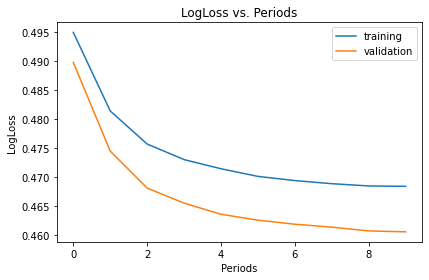

In [19]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000003,
    steps=20000,
    batch_size=500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])